In [1]:
import pandas as pd 
import numpy as np 
import sys 
import os 
import copy
import importlib
from csv import reader
# from plotnine import *
import plotly.graph_objects as go

#### Reading data and preprocessing

In [3]:
# Declare a path a folder before to read the function file out of current directory 
sys.path.insert(1, '../.')
from utils.GloSensorClass import GlosensorData
from utils.GloSensorClass import distinct_colors, continuous_colors


In [4]:
# UPDATE YOUR EXPERIMENT FILE HERE 
DATA_PATH = './data/'
file_extension = 'experiment_001'
path = os.path.join(DATA_PATH+file_extension+'/')


In [15]:
# Initiatate GlossensorData class 
glo = GlosensorData(path)
# Read in data from path
glo.ReadTableData()

Read Plate_1 
Read Plate_1_blank 


#### Checking plate values (Optional)

In [16]:
fig_list = glo.view_96well_curve(x_by = 'Time', 
                                 y_by = 'value',
                                 facet_col_by = 'Column', facet_row_by = 'Row',
                                 facet_col_spacing=0, facet_row_spacing=0,
                                 n_facet_col_wrap = 12)
for i in fig_list:
    i.show()

#### Set up plate transfection scheme 

In [17]:
"""
In the following chunk label your 96-well Plate based on the transfected schema
"""
glo.data.loc[(glo.data.Column.isin([1,2,3,4])), 'Odor'] = 'Galaxolide'
glo.data.loc[(glo.data.Column.isin([5,6,7,8,9,10,11,12])), 'Odor'] = 'Androstenone'

glo.data.loc[(glo.data.Column.isin([1])), 'Group'] = 'OR5A2_cTO_(GFP-PE+)'
glo.data.loc[(glo.data.Column.isin([2])), 'Group'] = 'OR5A2_cTO_(GFP+PE-)'
glo.data.loc[(glo.data.Column.isin([3])), 'Group'] = 'OR5A2_cTO_(GFP+PE+)'
glo.data.loc[(glo.data.Column.isin([4])), 'Group'] = 'OR5A2_cTO_(unsorted)'
glo.data.loc[(glo.data.Column.isin([5])), 'Group'] = 'OR7D4_(GFP-PE+)'
glo.data.loc[(glo.data.Column.isin([6])), 'Group'] = 'OR7D4_(GFP+PE-)'
glo.data.loc[(glo.data.Column.isin([7])), 'Group'] = 'OR7D4_(GFP+PE+)'
glo.data.loc[(glo.data.Column.isin([8])), 'Group'] = 'OR7D4_(unsorted)'
glo.data.loc[(glo.data.Column.isin([9])), 'Group'] = 'OR7D4_cTO_(GFP-PE+)'
glo.data.loc[(glo.data.Column.isin([10])), 'Group'] = 'OR7D4_cTO_(GFP+PE-)'
glo.data.loc[(glo.data.Column.isin([11])), 'Group'] = 'OR7D4_cTO_(GFP+PE+)'
glo.data.loc[(glo.data.Column.isin([12])), 'Group'] = 'OR7D4_cTO_(unsorted)'

glo.data.loc[(glo.data.Row.isin(['A','B'])), 'Odor_conc'] = 100
glo.data.loc[(glo.data.Row.isin(['C','D'])), 'Odor_conc'] = 10
glo.data.loc[(glo.data.Row.isin(['E','F'])), 'Odor_conc'] = 1
glo.data.loc[(glo.data.Row.isin(['G','H'])), 'Odor_conc'] = 0


In [5]:
# save data 
# glo.data.to_csv(file_extension+'.csv', index = 0)
# glo.data = pd.read_csv(file_extension+'.csv')

#### Normalize and generate dataframes for plotting 

In [18]:
# Raw data dataframes 
melted_data, \
    AUC_data, \
        slope_data = glo.get_melted_AUC_slope_data(group_col = ['Odor', 'Group', 'Odor_conc'], 
                                                                  slope_AUC_time = [0,3],
                                                                  data = glo.data)

In [19]:
# Normalize by Time_0 Usage
t_norm_data = glo.normalize_by_t(data = glo.data, 
                                 how = 'divide',
                                by_time = 1)
t_norm_melted_data, \
    t_norm_AUC_data, \
        t_norm_slope_data = glo.get_melted_AUC_slope_data(group_col = ['Odor', 'Group', 'Odor_conc'], 
                                                                  slope_AUC_time = [0,3],
                                                                  data = t_norm_data)

data normalized by Time_1 with divide


In [ ]:
# save data_summary 
# glo.melted_data.to_csv(file_extension+'_summary.csv')
# glo.melted_data = pd.read_csv(file_extension+'_summary.csv', index_col=0)

#### Raw scatter plot raw values

In [20]:
# Plot facet plots for individual raw values
plot_data = melted_data

fig = glo.plot_facet_line(plot_data, 
                          x_by = 'Time', 
                          y_by = 'mean', 
                          error_y_by = 'std',
                          color_by='Odor_conc', 
                          facet_col_by='Group',
                          #facet_row_by='Group', 
                          n_facet_col_wrap = 4)
fig.show()
# fig.write_html(f'./{file_extension}_raw_line.html')

#### Bar plot

In [23]:
# Plot facet plots for AUC

plot_data = AUC_data[['Odor_conc', 'Group', 'AUC_mean', 'AUC_std','Plate']]
plot_data = plot_data[plot_data.Plate.isin([1,2])]
plot_data = plot_data.sort_values('Group')
plot_data = plot_data.drop('Plate', axis = 1)
# Dropping duplicate is important for a functional bar graph 
plot_data = plot_data.drop_duplicates().reset_index(drop=True)

plot_data = plot_data[plot_data.Group != 'pCI_p2']

plot_data['Group'] = pd.Categorical(plot_data['Group'], categories=list(glo.data.Group.unique()), ordered=True)
plot_data = plot_data.sort_values(['Group', 'Odor_conc'], ascending=[True, False])
plot_data['Odor_conc'] = plot_data['Odor_conc'].astype(str)

fig = glo.plot_facet_bar(plot_data, 
                         x_by = "Odor_conc", 
                         y_by = "AUC_mean", 
                         facet_col_by = 'Group',
                        #  facet_row_by = 'Group',
                         error_y_by='AUC_std', n_facet_col_wrap = 4)
fig.show()
# fig.write_html(f'./{file_extension}_raw_AUC.html')

#### Sigmoid Dose Curve

                                 EC50      Max
Galaxolide_OR5A2_cTO_(unsorted) -5.06  2165.95
Galaxolide_OR5A2_cTO_(GFP+PE-)  -5.69  1096.84
Galaxolide_OR5A2_cTO_(GFP+PE+)  -5.80   259.77
Galaxolide_OR5A2_cTO_(GFP-PE+)  -4.22   211.98


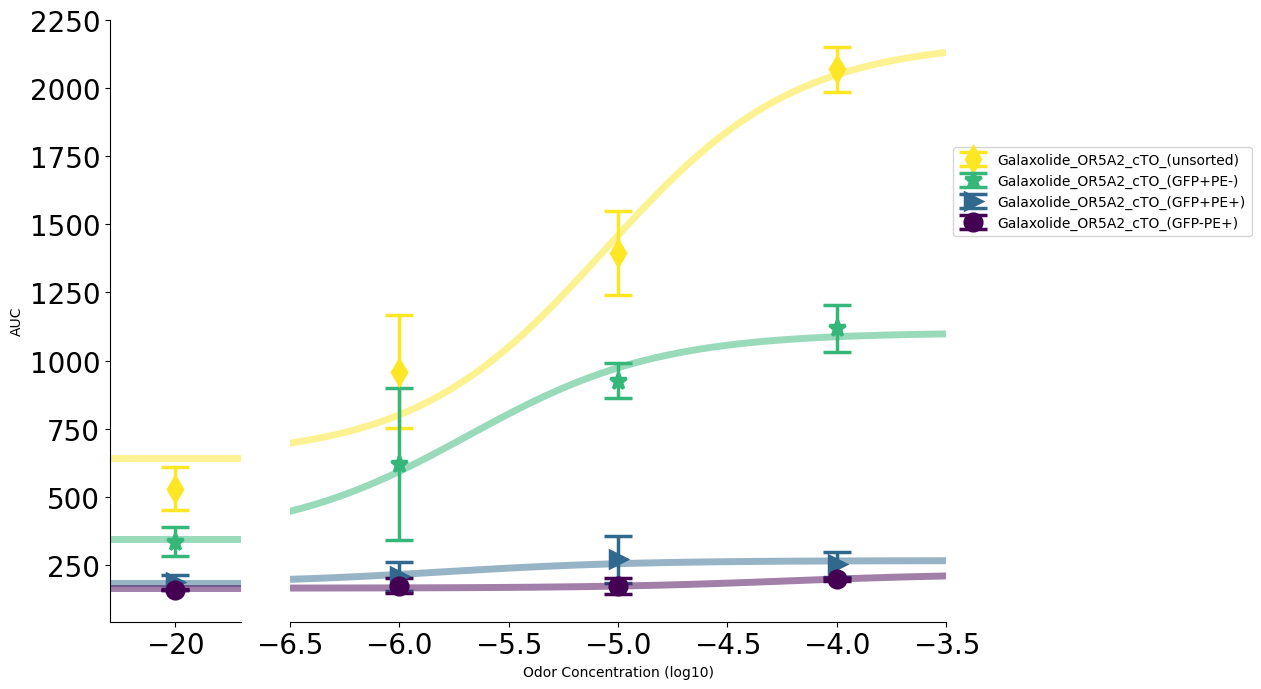

In [28]:
group_col = ['Odor', 'Group']

custom_color = [value for key, value in distinct_colors((['x'] * len(AUC_data.Group.unique())), 
                                                        category='pastel').items()]
# custom_color = ['#93aafa', '#beccfc', '#66c61c', '#a3dc76']
# custom_marker = ['o','o', 'v', 'v']
plot_data = AUC_data[AUC_data.Group.str.contains('OR5A2')]
# plot_data = AUC_data


fig, stat = glo.plot_Dose_curves(plot_data.sort_values('AUC', ascending=False), 
                                groupby_col = group_col, 
                                # custom_color=custom_color, 
                                # custom_marker=custom_marker,
                                figsize = (10,7), 
                                log_conc_offset=-6, 
                                # plot_points=True, 
                                x_by = 'Odor_conc', 
                                point_size = 12,
                                std_capsize=10,
                                std_linewidth=2.5,   
                                curve_width=5, 
                                sortlegend_by=None)
# fig.savefig(f'./{file_extension}_dosecurve.png', bbox_inches='tight')
print(pd.DataFrame(ec50).T)